In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

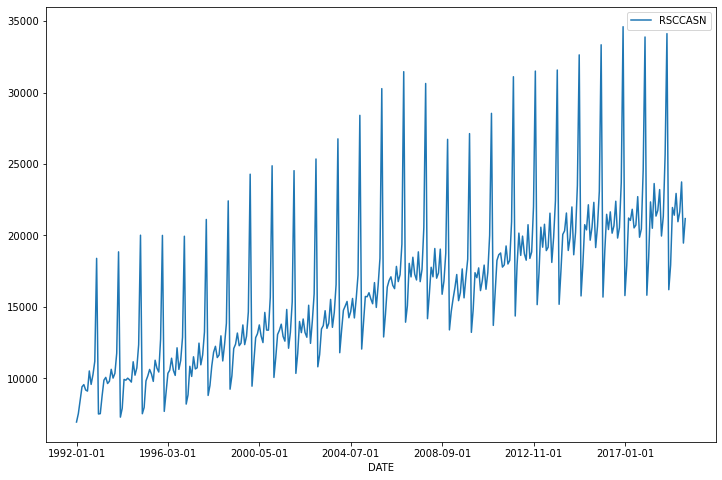

In [2]:
data=pd.read_csv('RSCCASN.csv',index_col='DATE')
data=data.iloc[:334]
data.plot(figsize=(12,8))

In [4]:
###################
#we will test on the last year and a half
test_indx=len(data)-18
train_df=data.iloc[:test_indx]
test_df=data.iloc[test_indx:]
##################################
#Lazm reshape 34an el MinMaxScaler expects 2d np arrays
x_train=np.array(train_df).reshape((316,1))
x_test=np.array(test_df).reshape((18,1))
####################################

In [5]:
from sklearn.preprocessing import MinMaxScaler
scaler=MinMaxScaler()
scaler.fit(x_train)
x_train=scaler.transform(x_train)
x_test=scaler.transform(x_test)
print(x_train.shape , x_test.shape)

(316, 1) (18, 1)


In [6]:
from keras.preprocessing.sequence import TimeseriesGenerator
train_generator = TimeseriesGenerator(x_train , x_train , batch_size=1 , length=12 ) #length 12 -> full year
#length = length of the input 
# data = labels ,
#batch size -> size to pass to fit func
########################################################
valid_generator= TimeseriesGenerator(x_test , x_test ,batch_size=1 , length=12 )
#########################################################
x,y=train_generator[0]
print(x,y) #x -> a year , y -> the next month

[[[0.        ]
  [0.02117588]
  [0.0555415 ]
  [0.08900372]
  [0.09467712]
  [0.08108987]
  [0.0782351 ]
  [0.12918729]
  [0.09521917]
  [0.11982799]
  [0.15354316]
  [0.41401366]]] [[0.02038088]]


In [7]:
########################## THE MODEL #######################
from keras.models import Sequential
from keras.layers import Dense , LSTM 
from keras.callbacks import EarlyStopping
early=EarlyStopping(patience=4 , monitor='val_loss')
model=Sequential()
model.add(LSTM(100,input_shape=(12,1) , activation='relu'))
model.add(Dense(1))
model.compile(optimizer='adam' , loss='mse')
########################### TRAINING #################
model.fit(train_generator , epochs=30 , callbacks=[early] , validation_data=valid_generator)

Epoch 1/30
304/304 [==============================] - 4s 8ms/step - loss: 0.0451 - val_loss: 0.0048
Epoch 2/30
304/304 [==============================] - 1s 3ms/step - loss: 0.0197 - val_loss: 0.0029
Epoch 3/30
304/304 [==============================] - 1s 3ms/step - loss: 0.0161 - val_loss: 0.0085
Epoch 4/30
304/304 [==============================] - 1s 3ms/step - loss: 0.0068 - val_loss: 8.0988e-04
Epoch 5/30
304/304 [==============================] - 1s 3ms/step - loss: 0.0028 - val_loss: 0.0046
Epoch 6/30
304/304 [==============================] - 1s 3ms/step - loss: 0.0031 - val_loss: 0.0016
Epoch 7/30
304/304 [==============================] - 1s 3ms/step - loss: 0.0021 - val_loss: 7.7681e-04
Epoch 8/30
304/304 [==============================] - 1s 3ms/step - loss: 0.0021 - val_loss: 9.5930e-04
Epoch 9/30
304/304 [==============================] - 1s 3ms/step - loss: 0.0025 - val_loss: 2.6221e-04
Epoch 10/30
304/304 [==============================] - 1s 3ms/step - loss: 8.0277e-0

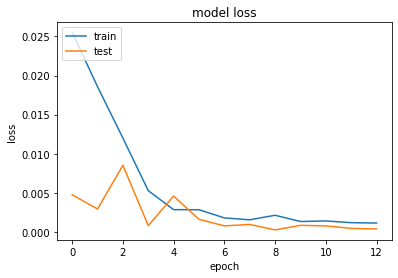

In [8]:
# summarize history for loss
plt.plot(model.history.history['loss'] )
plt.plot(model.history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [9]:
test_predictions=[]
first_batch=x_train[-12:]
current_batch=first_batch.reshape((1,12,1))
for i in range(len(x_test)):
    current_pred=model.predict(current_batch)[0]
    test_predictions.append(current_pred)
    current_batch=np.append(current_batch[:,1:,:] , [[current_pred]] , axis=1)
########################################
true_preds=scaler.inverse_transform(test_predictions)

In [10]:
test_df['Predictions'] = true_preds

<ipython-input-10-f32006841d50>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_df['Predictions'] = true_preds


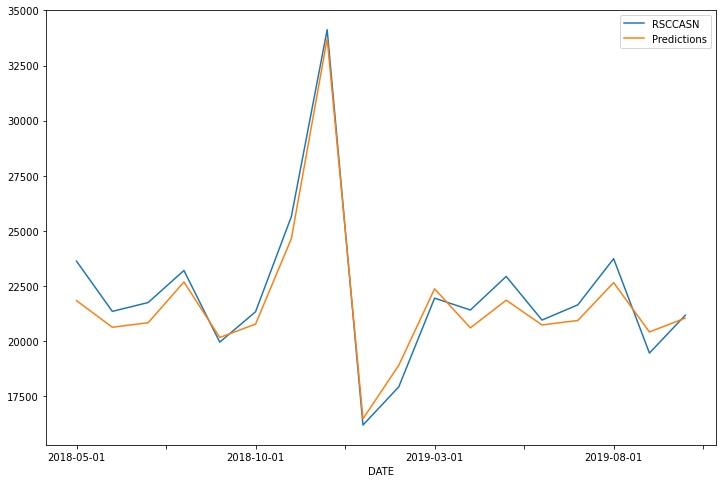

In [11]:
test_df.plot(figsize=(12,8))

In [ ]:
############ Forecasting into the future ####################

In [43]:
# Work on all the data
# 1-> scale
full_scaler=MinMaxScaler()
full_data=full_scaler.fit_transform(data)
#2-> creathe generator 
Full_generator = TimeseriesGenerator(full_data , full_data , batch_size=1 , length=12)
#3-> create the modell
model2=Sequential()
model2.add(LSTM(100,input_shape=(12,1) , activation='relu'))
model2.add(Dense(1))
model2.compile(optimizer='adam' , loss='mse')
model.fit(Full_generator , epochs=8)

Epoch 1/8
322/322 [==============================] - 1s 3ms/step - loss: 0.0011
Epoch 2/8
322/322 [==============================] - 1s 3ms/step - loss: 0.0011
Epoch 3/8
322/322 [==============================] - 1s 3ms/step - loss: 0.0012
Epoch 4/8
322/322 [==============================] - 1s 3ms/step - loss: 0.0011
Epoch 5/8
322/322 [==============================] - 1s 3ms/step - loss: 0.0013
Epoch 6/8
322/322 [==============================] - 1s 3ms/step - loss: 0.0011
Epoch 7/8
322/322 [==============================] - 1s 3ms/step - loss: 9.9927e-04
Epoch 8/8
322/322 [==============================] - 1s 3ms/step - loss: 0.0010


In [45]:
#Forecast into the future
forecast=[]
preiod=12
first_batch_full=full_data[-12:]
current_batch_full=first_batch_full.reshape((1,12,1))
for i in range(12):
    current_pred=model.predict(current_batch_full)[0]
    forecast.append(current_pred)
    current_batch_full=np.append(current_batch_full[:,1:,:] , [[current_pred]] , axis=1)
########################################
forecast=scaler.inverse_transform(forecast)

In [48]:
data

,RSCCASN
DATE,
1992-01-01,6938
1992-02-01,7524
1992-03-01,8475
1992-04-01,9401
1992-05-01,9558
...,...
2019-06-01,20960
2019-07-01,21650
2019-08-01,23743


In [49]:
forecast

array([[24511.02440846],
       [30795.58455759],
       [16398.29910061],
       [18038.62445843],
       [21190.10922921],
       [20773.81960627],
       [22042.45370662],
       [20439.44773847],
       [20962.09568387],
       [22702.78365219],
       [19220.7215488 ],
       [20625.59109101]])

In [50]:
forecast_indx=pd.date_range(start='2019-11-01' , periods=preiod , freq="MS")

In [51]:
forecast_indx

DatetimeIndex(['2019-11-01', '2019-12-01', '2020-01-01', '2020-02-01',
               '2020-03-01', '2020-04-01', '2020-05-01', '2020-06-01',
               '2020-07-01', '2020-08-01', '2020-09-01', '2020-10-01'],
              dtype='datetime64[ns]', freq='MS')

In [65]:
forecast_df=pd.DataFrame(data=forecast , index=forecast_indx , columns=['RSCCASN'])

In [72]:
forecast_df

,RSCCASN
2019-11-01,24511.024408
2019-12-01,30795.584558
2020-01-01,16398.299101
2020-02-01,18038.624458
2020-03-01,21190.109229
2020-04-01,20773.819606
2020-05-01,22042.453707
2020-06-01,20439.447738
2020-07-01,20962.095684
2020-08-01,22702.783652


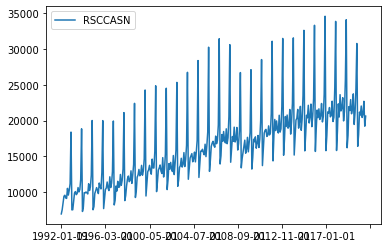

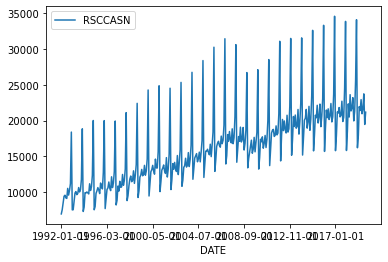

In [95]:
results=pd.concat([data , forecast_df])
results.plot()
data.plot()